✅ Dataset downloaded and extracted
Train sample: (30000, 3)
Test sample: (8000, 3)

✅ Accuracy: 0.8696

              precision    recall  f1-score   support

    Negative       0.88      0.85      0.86      3920
    Positive       0.86      0.89      0.87      4080

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000



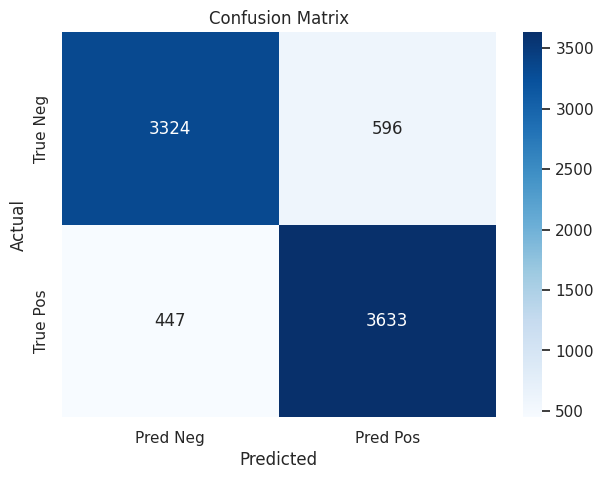

✅ Saved: ml_sentiment_predictions.csv


In [3]:
# ============================================================
# AMAZON REVIEW POLARITY – FAST, ROBUST, NO UPLOAD
# TF-IDF + Logistic Regression (Portfolio-Ready)
# ============================================================

# -----------------------------
# 1) Install deps
# -----------------------------
!pip -q install pandas scikit-learn matplotlib seaborn

import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)

# -----------------------------
# 2) Download dataset INSIDE Colab (fast)
# -----------------------------
DATA_URL = "https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz"
TGZ_NAME = "amazon_review_polarity_csv.tgz"
DATA_DIR = "amazon_review_polarity_csv"

if not os.path.exists(TGZ_NAME):
    !wget -q --show-progress -O {TGZ_NAME} {DATA_URL}

if not os.path.exists(DATA_DIR):
    !tar -xzf {TGZ_NAME}

train_path = os.path.join(DATA_DIR, "train.csv")
test_path  = os.path.join(DATA_DIR, "test.csv")

print("✅ Dataset downloaded and extracted")

# -----------------------------
# 3) Load CLEAN SAMPLES (robust CSV parsing)
# -----------------------------
N_TRAIN = 30000   # reduce/increase as needed
N_TEST  = 8000

train_df = pd.read_csv(
    train_path,
    header=None,
    names=["label", "title", "review"],
    sep=",",
    engine="python",
    quoting=csv.QUOTE_ALL,
    on_bad_lines="skip",   # 🔑 avoids malformed rows
    nrows=N_TRAIN
)

test_df = pd.read_csv(
    test_path,
    header=None,
    names=["label", "title", "review"],
    sep=",",
    engine="python",
    quoting=csv.QUOTE_ALL,
    on_bad_lines="skip",
    nrows=N_TEST
)

print("Train sample:", train_df.shape)
print("Test sample:", test_df.shape)

# -----------------------------
# 4) Prepare labels + text
# -----------------------------
# Labels: 1 = negative, 2 = positive
train_df["y"] = train_df["label"].map({1: 0, 2: 1})
test_df["y"]  = test_df["label"].map({1: 0, 2: 1})

# Combine title + review text
train_df["text"] = (train_df["title"].astype(str) + " " + train_df["review"].astype(str)).str.slice(0, 2000)
test_df["text"]  = (test_df["title"].astype(str) + " " + test_df["review"].astype(str)).str.slice(0, 2000)

# -----------------------------
# 5) TF-IDF Vectorization (FAST)
# -----------------------------
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=15000,     # speed knob
    ngram_range=(1, 1)      # faster than bigrams
)

X_train = vectorizer.fit_transform(train_df["text"])
X_test  = vectorizer.transform(test_df["text"])

y_train = train_df["y"].values
y_test  = test_df["y"].values

# -----------------------------
# 6) Train model (FAST)
# -----------------------------
model = LogisticRegression(max_iter=1000, n_jobs=-1)
model.fit(X_train, y_train)

# -----------------------------
# 7) Evaluate
# -----------------------------
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n✅ Accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Pred Neg", "Pred Pos"],
    yticklabels=["True Neg", "True Pos"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -----------------------------
# 8) Save predictions (for GitHub)
# -----------------------------
out = test_df[["label", "title", "review"]].copy()

# bring y into out (so mapping works)
out["y"] = test_df["y"].values

out["true_sentiment"] = out["y"].map({0: "Negative", 1: "Positive"})
out["pred_sentiment"] = pd.Series(y_pred).map({0: "Negative", 1: "Positive"})

out.to_csv("ml_sentiment_predictions.csv", index=False)
print("✅ Saved: ml_sentiment_predictions.csv")

